# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [3]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans # w tym pakiecie znajdziesz tez inne algorytmy
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [4]:
PATH = 'socialmediadata-beeradvocate/data/beer_reviews.csv'
POSITIVE_SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
NEGATIVE_SCORE_THRESHOLD = 2 # recenzje ponizej tego progu wezmiemy jako przyklady negatywne
ACTIVITY_THRESHOLD = 5 # minimalna liczba pozytywnych lub negatywnych recenzji per uzytkownik
MIN_SCORES_COUNT = 5 # minimalna liczba ocen pojedynczego elementu
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [5]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column

def parse_review(line: "list[str]", beer_id_column: int, beer_style_column: int, user_id_column: int, score_column: int):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path: str, positive_score_threshold: float, negative_score_threshold: float):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
    
        users_favourite_beers: dict[str,list[str]] = defaultdict(list)
        users_hated_beers: dict[str,list[str]] = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= positive_score_threshold:
                users_favourite_beers[user_id].append(beer_id)
            elif score <= negative_score_threshold:
                users_hated_beers[user_id].append(beer_id)

    return users_favourite_beers, users_hated_beers

def get_beer_id_to_style_mapping(path: str):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles: dict[str, str] = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers, users_hated_beers = read_and_parse_reviews(PATH, POSITIVE_SCORE_THRESHOLD, NEGATIVE_SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [6]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [7]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

from typing import Any
from numpy import dtype, floating, ndarray


def get_mean_vector_for_user(user_favourite_beers: "list[str]", model: Word2Vec, vector_size: int):
    # inicjalizujemy wektor zerami
    v: ndarray[Any, dtype[floating[Any]]] = np.zeros(vector_size)
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    # ...
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]
    
    # normalizujemy wektor - dzielimy kazda wspolrzedna przez liczbe piw
    # ...
    v /= len(user_favourite_beers)
    return v

def get_mean_user_vectors(users_favourite_beers: "dict[str,list[str]]", model: Word2Vec, vector_size: int):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors: dict[str, ndarray[Any, dtype[floating[Any]]]] = {}
    # ...
    for user_id, beer_ids in users_favourite_beers.items():
        mean_users_vectors[user_id] = get_mean_vector_for_user(beer_ids, model, vector_size)
    return mean_users_vectors

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

## Część 3. - klasteryzacja

In [8]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, porownaj co najmniej 2 rozne

DBSCAN_EPS = 0.5 # Parametr gęstości
DBSCAN_MIN_SAMPLES = 10 # Minimalna liczba próbek w klastrze

from sklearn.cluster import DBSCAN, AgglomerativeClustering


def get_users_segmentation(
        user_vectors: "dict[str, ndarray[Any, dtype[floating[Any]]]]", 
        vector_size: int, 
        segments_count: int, 
        clustering_algorithm: str):
    
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = user_vectors.keys()
    vectors = user_vectors.values()
    
    # zamieniamy liste wektorow w macierz
    users_array = np.vstack(list(vectors))
    # zaimplementuj wsparcie dla co najmniej dwoch algorytmow
    if clustering_algorithm == 'kmeans':
        clusters: ndarray[Any, Any] = KMeans(n_clusters=segments_count, n_init=10).fit_predict(users_array)
    elif clustering_algorithm == 'agglomerative':
        clusters: ndarray[Any, Any] = AgglomerativeClustering(n_clusters=segments_count, linkage='complete').fit_predict(users_array)
    elif clustering_algorithm == 'dbscan':
        clusters: ndarray[Any, Any] = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit_predict(users_array)
    else:
        raise ValueError('Clustering algorithm not supported. Supported algorithms: kmeans, agglomerative and dbscan.')
    
    segmentation: dict[str, ndarray[Any, Any]] = {}
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    # ...
    segmentation = {user_id: cluster for user_id, cluster in zip(users, clusters)}
    return segmentation

segmentation1 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
segmentation2 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

In [9]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation: "dict[str, Any]"):
    return Counter(segmentation.values())

print(get_segment_sizes(segmentation1))
print(get_segment_sizes(segmentation2))

Counter({9: 12389, 2: 6581, 5: 2077, 0: 1629, 4: 1529, 6: 1369, 1: 1243, 8: 1225, 3: 1145, 7: 1099})
Counter({2: 19399, 1: 2832, 3: 2138, 0: 2066, 4: 1249, 5: 716, 9: 579, 7: 496, 8: 442, 6: 369})


In [10]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci [-1, 1] - im wiecej, tym lepiej


users, user_vectors_list = zip(*user_vectors.items())
segments_list1: "list[Any]" = [segmentation1[u] for u in users]
segments_list2: "list[Any]" = [segmentation2[u] for u in users]

mean_silhouette1 = silhouette_score(user_vectors_list, segments_list1, metric='euclidean')
per_sample_silhouettes1 = silhouette_samples(user_vectors_list, segments_list1, metric='euclidean')

mean_silhouette2 = silhouette_score(user_vectors_list, segments_list2, metric='euclidean')
per_sample_silhouettes2 = silhouette_samples(user_vectors_list, segments_list2, metric='euclidean')

In [11]:
# rysujemy wykres


def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height*1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

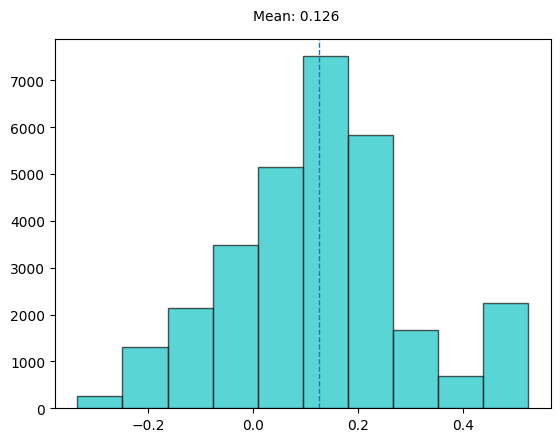

In [12]:
plot_histogram(per_sample_silhouettes1, mean_silhouette1)

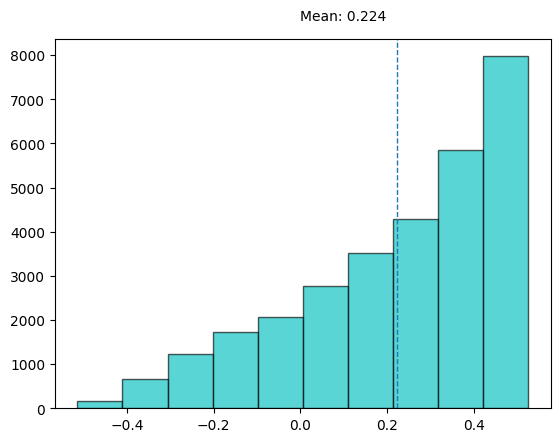

In [13]:
plot_histogram(per_sample_silhouettes2, mean_silhouette2)

## Część 3.5. - negative sampling

Wykonaj kroki obliczania embeddingów uytkowników, klasteryzacji z uyciem najlepszego według Ciebie algorytmu i obliczania sylwetki - ale tym razem embeddingi to średnia waona, gdzie elementy `users_favourite_beers[user_id]` mają wagę `1`, a elementy `users_hated_beers[user_id]` mają wagę `-1`.

Możesz także odsiać tych użytkowników, o których wiemy zbyt mało (czyli którzy mają łącznie mniej niż `ACTIVITY_THRESHOLD` elementów w listach `users_favourite_beers[user_id]` i `users_hated_beers[user_id]`).

In [14]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model_hated = Word2Vec(sentences=users_hated_beers.values(), size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [15]:
# Obliczanie embeddingów użytkowników (średnia ważona wektorów)

def get_weighted_vector_for_user(
    user_favourite_beers: "list[str]",
    user_hated_beers: "list[str]",
    model_favourite: Word2Vec,
    model_hated: Word2Vec,
    vector_size: int):
    
    v: ndarray[Any, dtype[floating[Any]]] = np.zeros(vector_size)
    
    for beer_id in user_favourite_beers:
        v += model_favourite.wv[beer_id]
    
    for beer_id in user_hated_beers:
        v -= model_hated.wv[beer_id]
    
    v /= len(user_favourite_beers) + len(user_hated_beers)
    return v

def get_weighted_user_vectors(
    users_favourite_beers: "dict[str,list[str]]",
    users_hated_beers: "dict[str,list[str]]",
    model_favourite: Word2Vec,
    model_hated: Word2Vec,
    vector_size: int,
    activity_threshold: int):

    weighted_users_vectors: dict[str, ndarray[Any, dtype[floating[Any]]]] = {}
    
    for user_id in users_favourite_beers.keys():
        favourite_beers = users_favourite_beers[user_id]
        hated_beers = users_hated_beers.get(user_id, [])
        
        if len(favourite_beers) + len(hated_beers) < activity_threshold:
            continue

        weighted_users_vectors[user_id] = get_weighted_vector_for_user(
            favourite_beers, hated_beers, model_favourite, model_hated, vector_size)
        
    return weighted_users_vectors

weighted_user_vectors = get_weighted_user_vectors(
    users_favourite_beers, users_hated_beers, model, model_hated, VECTOR_SIZE, ACTIVITY_THRESHOLD)

In [16]:
segmentation_weighted_1 = get_users_segmentation(weighted_user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
segmentation_weighted_2 = get_users_segmentation(weighted_user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

In [17]:
print(get_segment_sizes(segmentation_weighted_1))
print(get_segment_sizes(segmentation_weighted_2))

users_weighted, user_weighted_vectors_list = zip(*weighted_user_vectors.items())
segments_list_weighted_1: "list[Any]" = [segmentation_weighted_1[u] for u in users_weighted]
segments_list_weighted_2: "list[Any]" = [segmentation_weighted_2[u] for u in users_weighted]

mean_silhouette_weighted_1 = silhouette_score(user_weighted_vectors_list, segments_list_weighted_1, metric='euclidean')
per_sample_silhouettes_weighted_1 = silhouette_samples(user_weighted_vectors_list, segments_list_weighted_1, metric='euclidean')

mean_silhouette_weighted_2 = silhouette_score(user_weighted_vectors_list, segments_list_weighted_2, metric='euclidean')
per_sample_silhouettes_weighted_2 = silhouette_samples(user_weighted_vectors_list, segments_list_weighted_2, metric='euclidean')

Counter({1: 2314, 0: 2287, 6: 2059, 3: 1783, 9: 997, 4: 788, 5: 780, 8: 750, 2: 665, 7: 616})
Counter({2: 9288, 1: 1936, 3: 628, 8: 602, 6: 186, 4: 183, 5: 95, 9: 61, 0: 59, 7: 1})


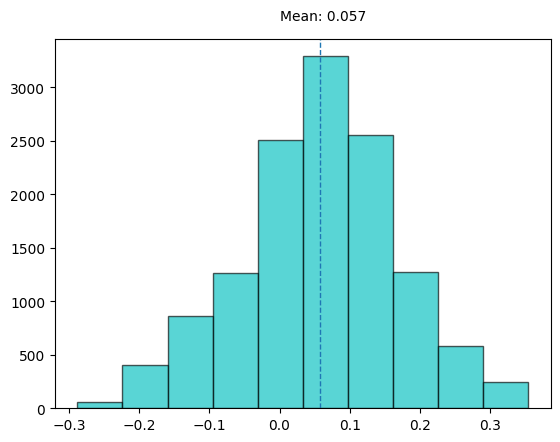

In [18]:
plot_histogram(per_sample_silhouettes_weighted_1, mean_silhouette_weighted_1)

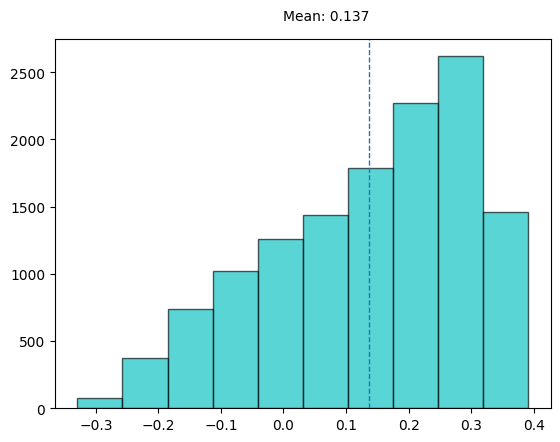

In [19]:
plot_histogram(per_sample_silhouettes_weighted_2, mean_silhouette_weighted_2)

## Część 4. - opisy segmentów

In [20]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(
        users_favourite_beers: "dict[str,list[str]]", 
        beer_styles: "dict[str,str]", 
        segmentation: "dict[str, Any]", 
        segments_count: int):
    
    beer_styles_per_segment: dict[int,dict[str,int]] = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]
    
    for user, beers in users_favourite_beers.items():
        segment = segmentation[user]
        for beer in beers:
            beer_styles_per_segment[segment][beer_styles[beer]] += 1
    
    return beer_styles_per_segment

def get_total_styles_popularity(beer_styles_per_segment: "dict[int,dict[str,int]]"):
    total_popularity: dict[str,int] = defaultdict(lambda: 0)
    for segment_popularity in beer_styles_per_segment.values():
        for style, popularity in segment_popularity.items():
            total_popularity[style] += popularity
    return total_popularity

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation2, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [21]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity: "dict[int,dict[str,int]]", N: int):
    return {segment_id: dict(Counter(styles).most_common(N)) for segment_id, styles in per_segment_styles_popularity.items()}

def most_distinctive_styles_per_segment(total_styles_popularity: "dict[str,int]", per_segment_styles_popularity: "dict[int,dict[str,int]]", N: int):
    return {segment_id: {style: popularity/total_styles_popularity[style] for style, popularity in Counter(styles).most_common(N)} for segment_id, styles in per_segment_styles_popularity.items()}
     
top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

## Część 5. - wizualizacja

In [22]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

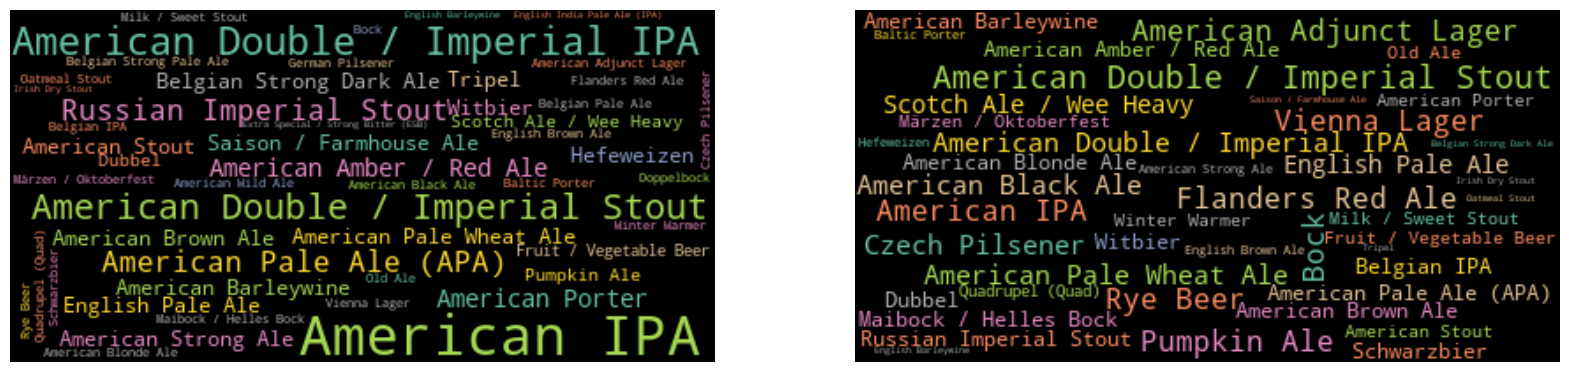

In [23]:
visualise_styles(most_popular, most_distinctive, 1)

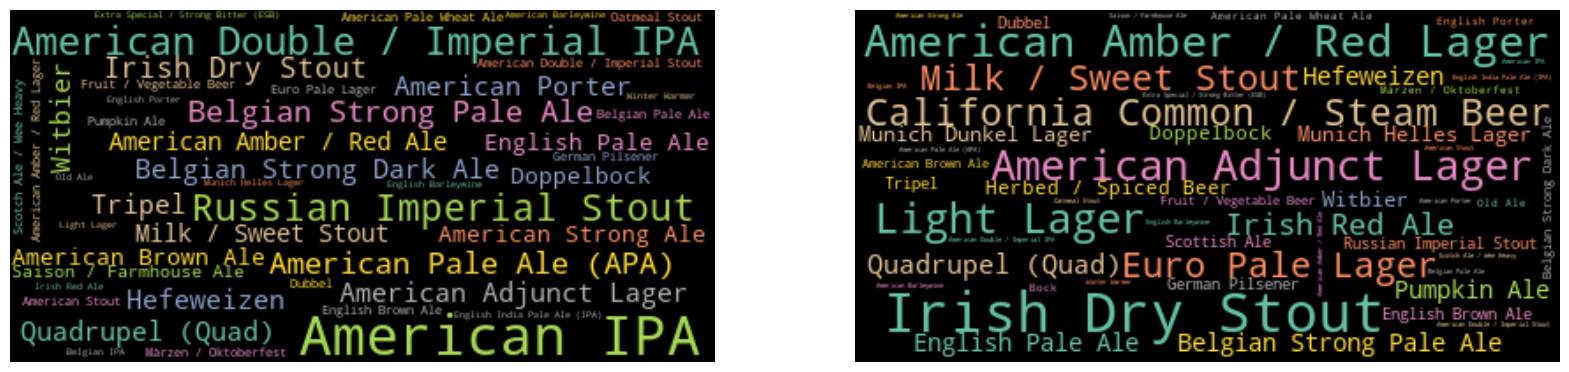

In [24]:
visualise_styles(most_popular, most_distinctive, 3)